In [ ]:
#| export
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

from sklearn.preprocessing import StandardScaler
from pathlib import Path

In [ ]:
#| export
import torch
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

from sklearn.preprocessing import StandardScaler
from pathlib import Path

import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager
from warnings import warn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from torcheval.metrics import MeanSquaredError,Mean, R2Score
from fastprogress import progress_bar,master_bar

from hybridpredictmaize22.GEMdataset import *
from hybridpredictmaize22.GEMlearn import *

In [ ]:
test_split = 2019
path_snps = Path('data/snpCompress/')
data_path = Path('data/')
path_train_weatherTable =data_path/'Training_Data/4_Training_Weather_Data_2014_2021.csv'
path_train_yieldTable = data_path/'Training_Data/1_Training_Trait_Data_2014_2021.csv'
snp_compression = 'PCS_50'
batch_size = 64

In [ ]:
#| export
def remove_leapdays(weather_data):
    """ just a hotfix """
    to_remove = []
    for i in list(set(weather_data['Env'])):
        if (sum(weather_data['Env'] == i)) == 366:
            #get indexes
            to_remove.append(max(list(weather_data.loc[weather_data['Env'] == i].index)))
    return weather_data.drop(to_remove)

In [ ]:
snp_data = collect_snps(path_snps/snp_compression) # Read in the SNP profiles
yield_data = pd.read_csv(path_train_yieldTable) # Read in trait data 
yield_data = yield_data[yield_data['Yield_Mg_ha'].notnull()] #Remove plots w/ missing yields
weather_data = pd.read_csv(path_train_weatherTable) # Read in Weather Data
weather_data['Year'] = [x.split('_')[1] for x in weather_data['Env']] #Store Year in a new column
#removes yield data where no weather data
setYield = set(yield_data['Env'])
setWeather = set(weather_data['Env'])
only_yield = setYield - setWeather
only_weather = setWeather - setYield
yield_data = yield_data.iloc[[x not in only_yield for x in yield_data['Env']],:]
#removes yield data where no genotype data
setSNP = set(snp_data[0])
setYield = set(yield_data['Hybrid'])
only_yield = setYield - setSNP
yield_data = yield_data.iloc[[x not in only_yield for x in yield_data['Hybrid']],:]

weather_data = remove_leapdays(weather_data)
weather_data = weather_data.reset_index()
yield_data=yield_data.sample(frac=1)
yield_data = yield_data.reset_index()

In [ ]:
import torch
import torch.nn as nn

# Define the model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x

# Instantiate the model
model = MLP(input_size=100, hidden_size=64, output_size=1)

# Generate some random input data
input_data = torch.randn(32, 100)

# Make a prediction
output = model(input_data)

In [ ]:
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch import tensor,nn,optim
import torch.nn.functional as F


In [ ]:

#Create a GEM dataset
gem = GEM(test_split)

gem.Y = YT(yield_data, test_split)
gem.W = WT(weather_data, test_split)
gem.SNP = snp_data

tr_ds = GemDataset(gem.W.Tr, gem.Y.Tr, gem.SNP)
te_ds = GemDataset(gem.W.Te, gem.Y.Te, gem.SNP)

tr_dataloader = DataLoader(tr_ds, batch_size=batch_size, shuffle=True)
te_dataloader = DataLoader(te_ds, batch_size=batch_size, shuffle=True)

dls = (tr_dataloader, te_dataloader)


In [ ]:

losses = []
model = MLP(100,100,1)
opt = torch.optim.SGD(model.parameters(), lr=.05)
loss_func = F.mse_loss
for c, (y,g,w) in enumerate(tr_dataloader):
    g = g.type(torch.float32)
    #print(g.shape)
    preds = model(g)
    y = y.type(torch.float32)
    loss = loss_func(preds.squeeze(),y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    #print(preds[0])
    losses.append(loss.detach().numpy())
    
    if preds[0].isnan()[0] == True:
        print('nan')
    
    if c > 500:
        print(c)
        break
    

501


[<matplotlib.lines.Line2D>]

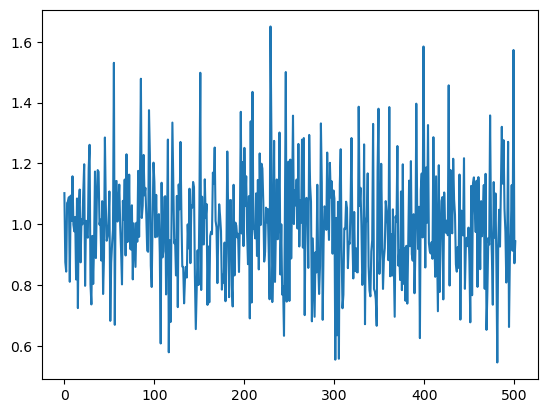

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)

In [ ]:
g.shape

torch.Size([64, 100])

In [ ]:
class Enformer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Enformer, self).__init__()
        
        self.trans1 = nn.Transformer.

In [ ]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.transformer = nn.Transformer(input_dim, nhead=10)
        self.regress = nn.Linear(100,1)
    def forward(self, x):
        x = self.transformer(x,x)
        x = self.regress(x)
        return x
# create the model
model = TransformerModel(input_dim=100, output_dim=1)